### Empirical mode decomposition of the signal

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import PyEMD
import skimage as ski
import xarray as xr
from frites.utils import parallel_func
from mne.time_frequency import (
    psd_array_multitaper,
    tfr_array_morlet,
    tfr_array_multitaper,
)
from scipy.optimize import curve_fit
from skimage.segmentation import watershed
from tqdm import tqdm

from VUDA.io.loadbinary import LoadBinary

ModuleNotFoundError: No module named 'PyEMD'

#### Functions

In [2]:
import logging

from frites.utils import parallel_func


def _emd(
    data: np.ndarray,
    trials: int,
    max_imf: int = 10,
    block_size=None,
    n_jobs: int = 1,
    verbose: bool = False,
    seed: int = 0,
    method="emd",
):

    assert method in ["emd", "eemd"]

    if method == "emd":
        logging.warning("For method EMD, trials is set to 1.")
        trials = 1

    n_samples = data.shape[0]

    _emd = PyEMD.EEMD(trials=trials)
    _emd.noise_seed(seed)

    if method == "emd":
        f_emd = _emd.emd
    else:
        f_emd = _emd.eemd

    if isinstance(block_size, int) and (block_size > 1):
        blocks = np.array_split(np.arange(n_samples), block_size)
    else:
        blocks = [np.arange(n_samples)]

    nblocks = len(blocks)

    IMDs = []

    def _for_block(block):

        return _emd.eemd(data[block], progress=False, max_imf=max_imf)

    # define the function to compute in parallel
    parallel, p_fun = parallel_func(
        _for_block, verbose=verbose, n_jobs=n_jobs, total=nblocks
    )

    out = parallel(p_fun(block) for block in blocks)

    return out


def get_composite_signal(
    IMFs: list,
    sfreq: int,
    cutoff: int,
    fmin=0,
    fmax=300,
    bandwidth=4,
    n_jobs=1,
    verbose: bool = False,
):

    n_trials = len(IMFs)

    __iter = range(ntrials)

    filtered = []
    psds = []
    freqs = []

    def _for_trial(i):

        psd, f = psd_array_multitaper(
            IMFs[i],
            fmin=fmin,
            fmax=fmax,
            sfreq=sfreq,
            verbose=False,
            bandwidth=bandwidth,
            n_jobs=n_jobs,
        )

        psd = np.log(psd)

        freqs += [f]
        idx = np.where(f[psd.argmax(axis=1)] > cutoff)[0]
        filtered += [IMFs[i][idx].mean(0)]
        psds += [psd[idx].mean(0)]

    for i in __iter:

        psd, f = psd_array_multitaper(
            IMFs[i],
            fmin=fmin,
            fmax=fmax,
            sfreq=sfreq,
            verbose=False,
            bandwidth=bandwidth,
            n_jobs=n_jobs,
        )

        psd = np.log(psd)

        freqs += [f]
        idx = np.where(f[psd.argmax(axis=1)] > 40)[0]
        filtered += [IMFs[i][idx].mean(0)]
        psds += [psd[idx].mean(0)]

#### Load data

In [3]:
filepath = "/home/vinicius/funcog/vanderbilt/neural_data/aHPC_B_cnct.dat"

In [4]:
# Load binaries
data = LoadBinary(
    filepath,
    frequency=30000,
    nSamplesPerChannel=None,
    channels=[33],
    downsample=30,
    bitVolts=0.195,
    nChannels=64,
    precision=np.int16,
    verbose=False,
)

In [5]:
# Decompose in IMFs
IMFs = _emd(
    data.squeeze().data,
    trials=50,
    max_imf=None,
    method="eemd",
    block_size=1000,
    n_jobs=30,
    verbose=True,
)

  0%|          |  : 0/1000 [00:00<?,       ?it/s]

[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done 140 tasks      | elapsed:  4.9min
[Parallel(n_jobs=30)]: Done 390 tasks      | elapsed: 13.0min
[Parallel(n_jobs=30)]: Done 740 tasks      | elapsed: 24.5min
[Parallel(n_jobs=30)]: Done 1000 out of 1000 | elapsed: 32.9min finished


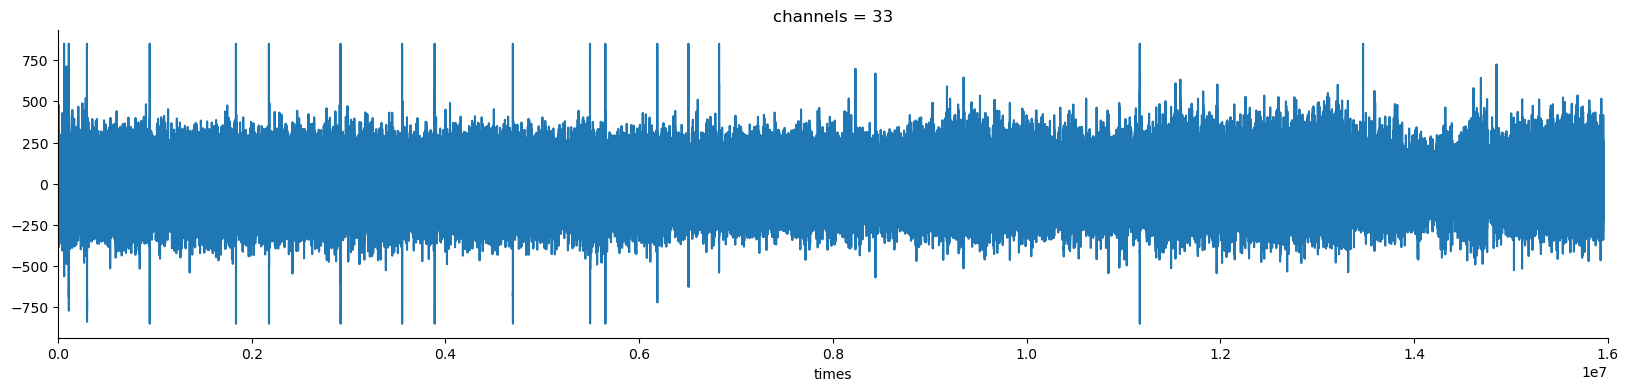

In [6]:
plt.figure(figsize=(20, 4))
ax = plt.subplot(111)
data.plot()
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.xlim(0, 1.6e7);

#### Decompose signal in IMFs

##### Example on a snippet

In [7]:
x = data.squeeze()[:5000].data

_emd = PyEMD.EEMD(trials=50)
_emd.noise_seed(1234546)

imf = _emd.eemd(x, progress=False, max_imf=None)

z_imf = (imf - imf.mean(1)[:, None]) / imf.std(1)[:, None]

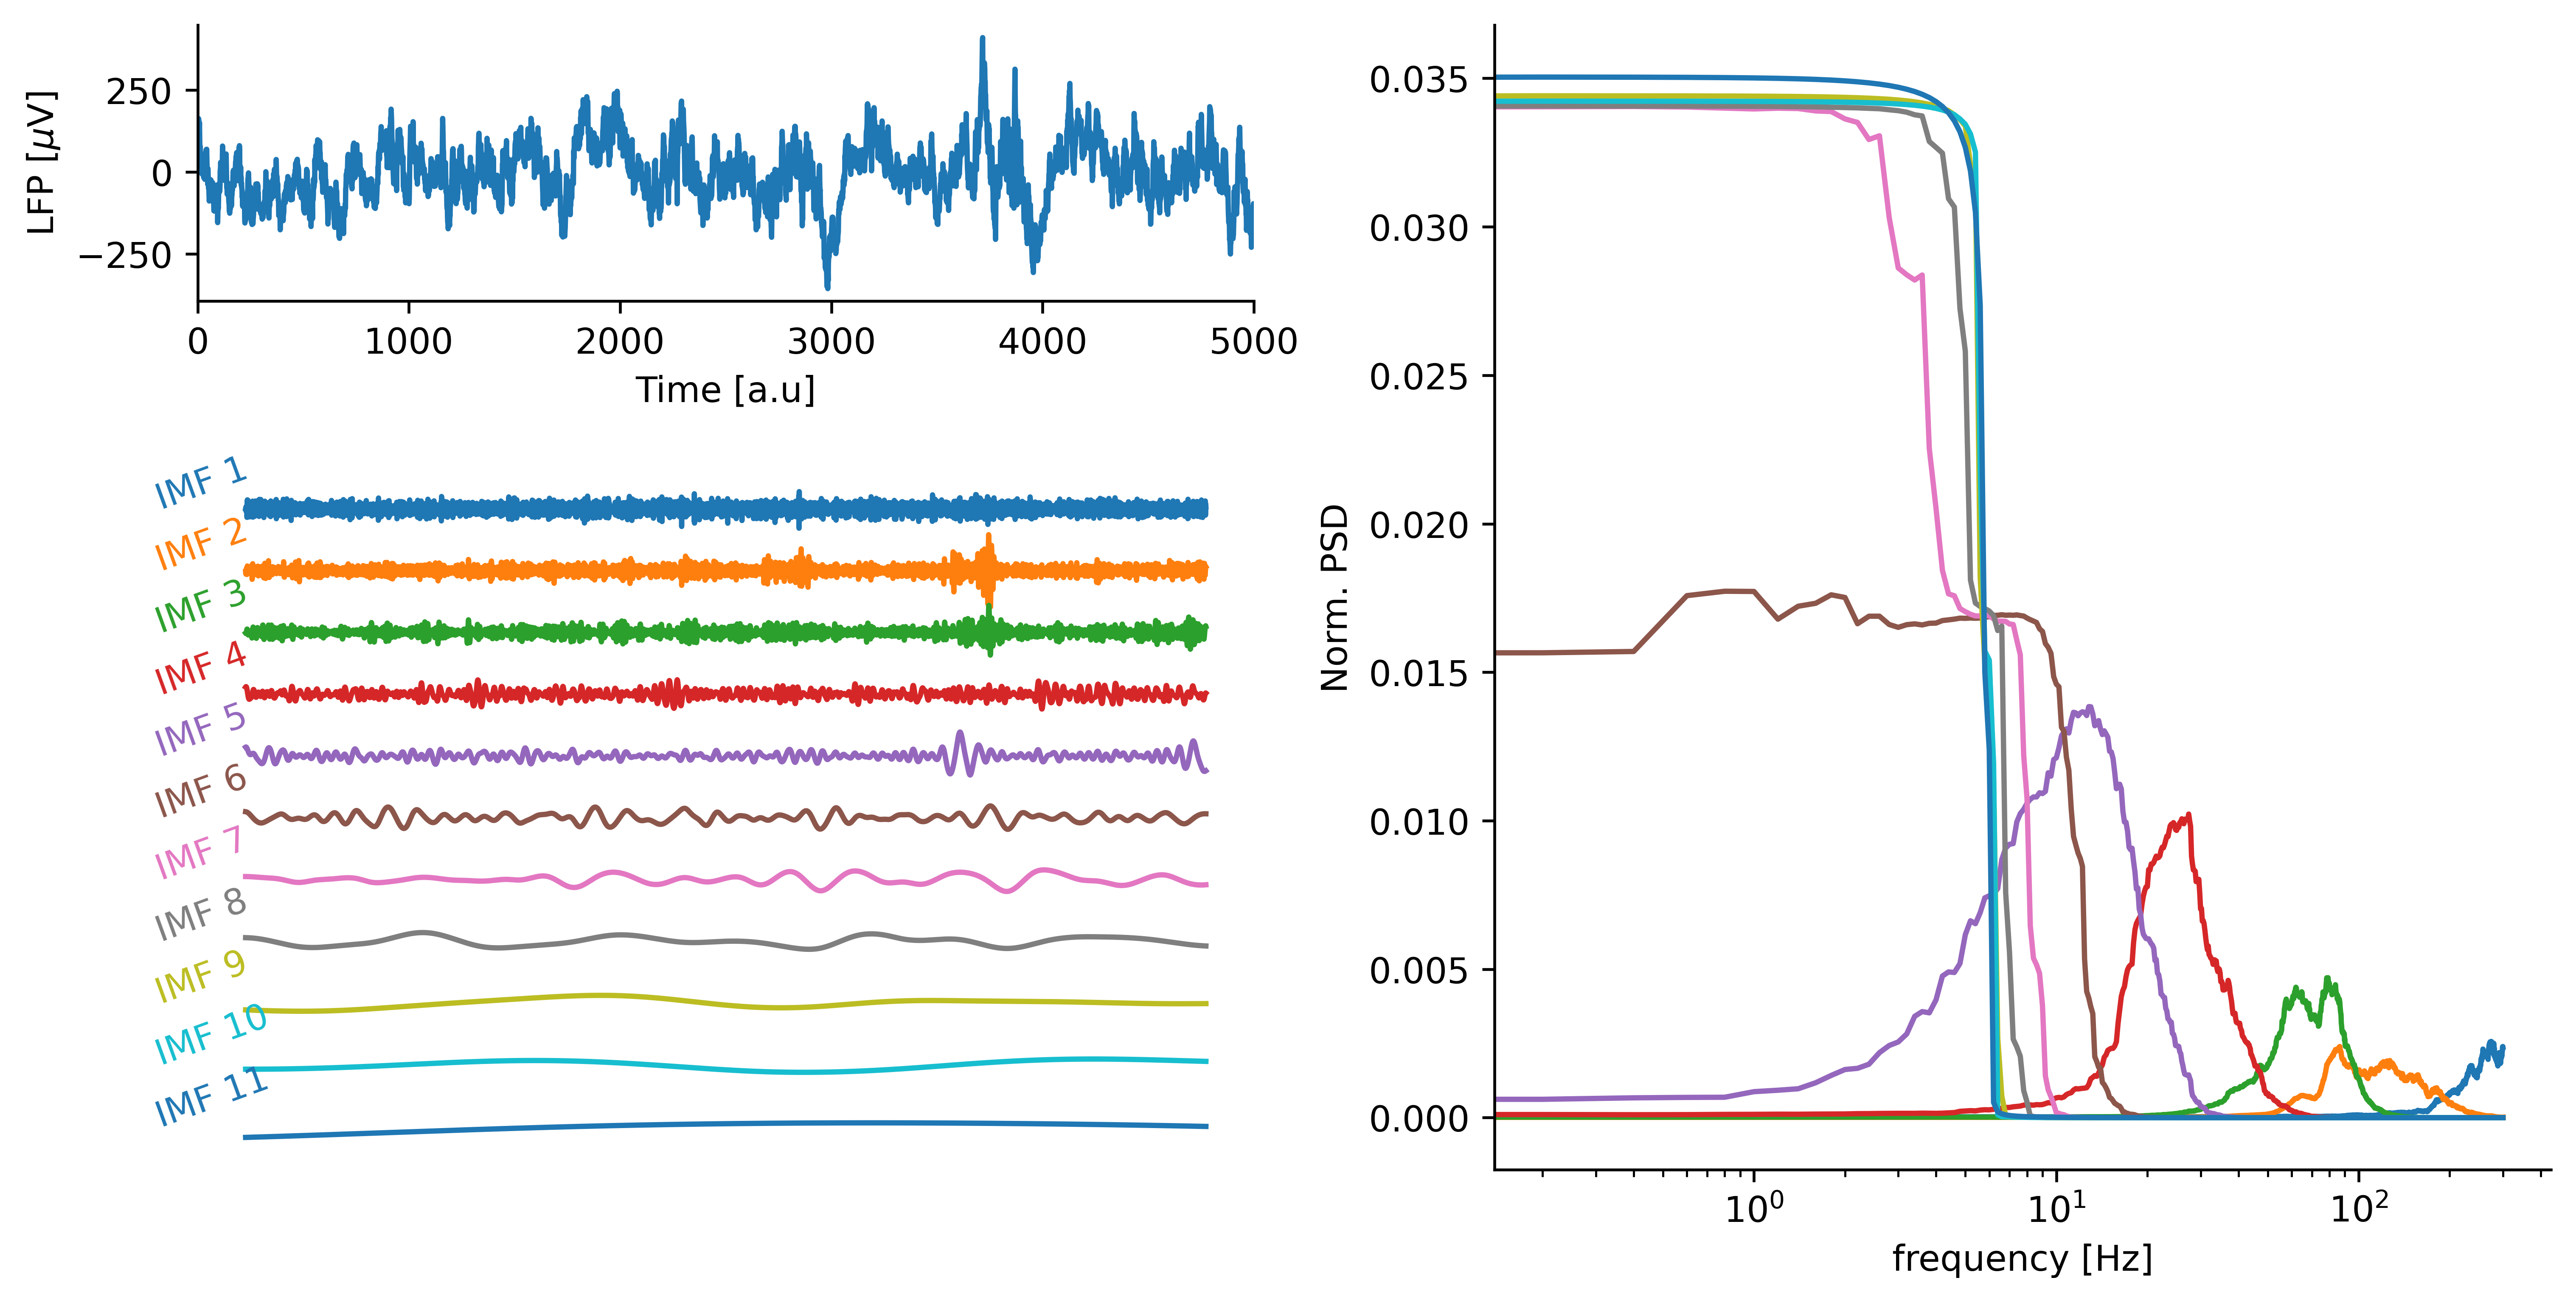

In [8]:
fig, axd = plt.subplot_mosaic(
    [["A", "A", "C", "C"], ["B", "B", "C", "C"], ["B", "B", "C", "C"]],
    layout="constrained",
    figsize=(10, 5),
    dpi=600,
)

# Plot the signal snippet
plt.sca(axd["A"])
plt.plot(x)
plt.xlim(0, 5000)
plt.xlabel("Time [a.u]")
plt.ylabel(r"LFP [$\mu$V]")
[axd["A"].spines[key].set_visible(False) for key in ["top", "right"]]

# Plot the signal IMFs
plt.sca(axd["B"])
colors = []
for i in range(imf.shape[0]):
    p_ = plt.plot(z_imf[i] + 14.5 * (z_imf.shape[0] - i))
    colors += [p_[0].get_color()]
    plt.text(
        -490,
        14.5 * (z_imf.shape[0] - i),
        f"IMF {i + 1}",
        color=colors[-1],
        rotation=20,
    )
    plt.axis("off")


psd, f = psd_array_multitaper(
    imf,
    fmin=0,
    fmax=300,
    sfreq=1000,
    verbose=False,
    bandwidth=12,
    n_jobs=10,
)

plt.sca(axd["C"])
for i in range(len(psd)):
    plt.semilogx(f, psd[i] / psd[i].sum())
plt.xlabel("frequency [Hz]")
plt.ylabel("Norm. PSD")
[axd["C"].spines[key].set_visible(False) for key in ["top", "right"]]

plt.savefig("figures/emf_snippet_example.png")

#### Decompose signal in IMFs for all the batches

In [9]:
def gauss(x, a, x0, sigma):
    return a * np.exp(-((x - x0) ** 2) / (2 * sigma**2))


def gaussian_fit(y, x):
    try:
        popt, pcov = curve_fit(gauss, x, y, p0=[1, x[y.argmax()], 1])
    except:
        popt = np.nan
    return popt

In [10]:
"""
theta_composite = []
gamma_composite = []

for i in tqdm(range(1)):

    psd, f = psd_array_multitaper(
        IMFs[i], fmin=0, fmax=300, sfreq=1000, verbose=False, bandwidth=4, n_jobs=30
    )

    # Fit a gaussian to each spectrum and get their first momentum
    popt = np.apply_along_axis(gaussian_fit, 1, psd, f)
    mu = popt[:, 1]

    # theta composite
    theta_peaks = np.logical_and(mu >= 3, mu < 8)
    idx = np.where(theta_peaks)[0]
    theta_composite.append(IMFs[i][idx].sum(0))
    # gamma composite
    gamma_peaks = np.logical_and(mu >= 40, mu < 150)
    idx = np.where(gamma_peaks)[0]
    gamma_composite.append(IMFs[i][idx].sum(0))
""";

In [11]:
def _for_batch(IMF: list, bands: list, band_names: list = None):

    n_imfs, n_times = IMF.shape
    n_bands = len(bands)

    if not isinstance(band_names, (list, np.ndarray)):
        band_names = np.median(bands, axis=1).astype(int)

    psd, f = psd_array_multitaper(
        IMF, fmin=0, fmax=300, sfreq=1000, verbose=False, bandwidth=4, n_jobs=1
    )

    # Fit a gaussian to each spectrum and get their first momentum
    popt = np.apply_along_axis(gaussian_fit, 1, psd, f)
    mu = popt[:, 1]

    # Composite signals
    composite = np.empty((n_bands, n_times))

    for pos, (f_l, f_h) in enumerate(bands):
        peaks = np.logical_and(mu >= f_l, mu < f_h)
        idx = np.where(peaks)[0]
        composite[pos] = IMF[idx].sum(0)

    dims = ("bands", "times")
    coords = {"bands": band_names}

    composite = xr.DataArray(composite, dims=dims, coords=coords)

    return composite


# define the function to compute in parallel
parallel, p_fun = parallel_func(_for_batch, n_jobs=30, verbose=False, total=len(IMFs))
# Compute the single trial coherence
composite = parallel(p_fun(IMF, [[3, 8], [40, 150]]) for IMF in IMFs)

  0%|          |  : 0/1000 [00:00<?,       ?it/s]

In [12]:
lengths = np.asarray([signal.shape[1] for signal in composite])

In [13]:
composite = xr.concat([signal[:, 0 : lengths.min()] for signal in composite], "batches")

Text(0.5, 0, 'Time')

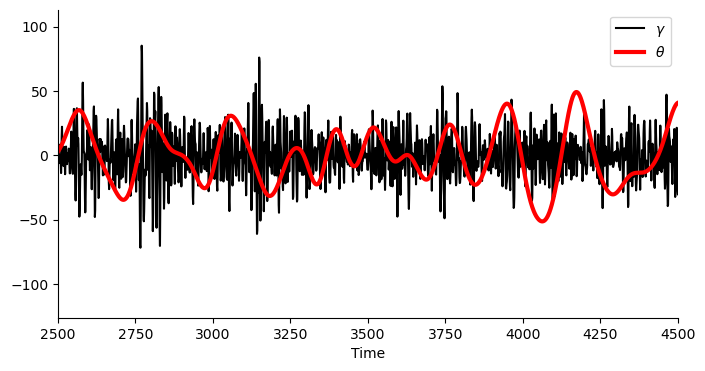

In [14]:
plt.figure(figsize=(8, 4))
ax = plt.subplot(111)
plt.plot(np.squeeze(composite[100][1]), "k", label=r"$\gamma$")
plt.plot(np.squeeze(composite[100][0]), "r", lw=3, label=r"$\theta$")
plt.legend()
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.xlim(2500, 4500)
plt.xlabel("Time")

#### Decompose signal in time-frequency domain

In [15]:
freqs = np.linspace(3, 10, 50)

W_theta = tfr_array_morlet(
    composite.isel(bands=[0]),
    1000,
    freqs,
    n_cycles=12,
    n_jobs=30,
).squeeze()

dims = ("batches", "freqs", "times")
coords = dict(freqs=freqs)
W_theta = xr.DataArray((W_theta * W_theta.conj()).real, dims=dims, coords=coords)

[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   1 out of   1 | elapsed:  1.2min finished


In [16]:
freqs = np.linspace(40, 150, 50)

W_gamma = tfr_array_morlet(
    composite.isel(bands=[1]),
    1000,
    freqs,
    n_cycles=freqs / 2,
    n_jobs=30,
).squeeze()

dims = ("batches", "freqs", "times")
coords = dict(freqs=freqs)
W_gamma = xr.DataArray((W_gamma * W_gamma.conj()).real, dims=dims, coords=coords)

[Parallel(n_jobs=30)]: Using backend LokyBackend with 30 concurrent workers.
[Parallel(n_jobs=30)]: Done   1 out of   1 | elapsed:  1.1min finished


In [17]:
x = composite.isel(bands=0, batches=0)
y = composite.isel(bands=1, batches=0)

x = (x - x.mean("times")) / (7 * x.std("times"))
y = (y - y.mean("times")) / (y.std("times"))

(2500.0, 5000.0)

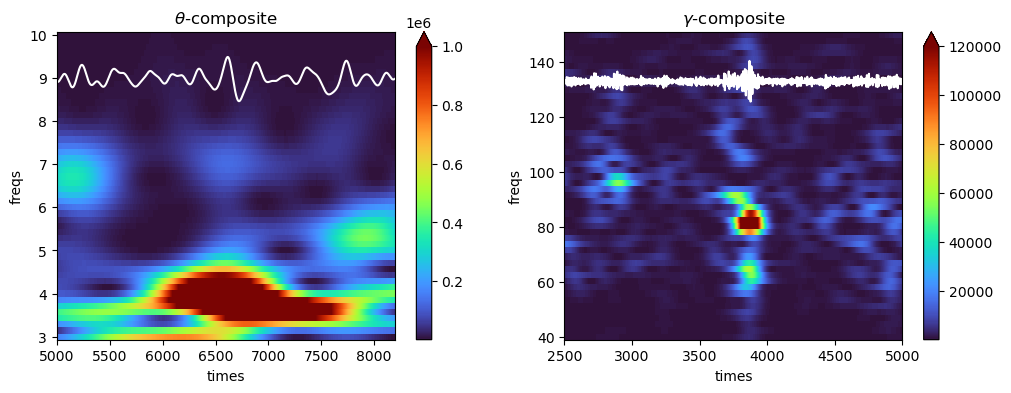

In [18]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
W_theta[0].plot(cmap="turbo", vmax=1e6)
plt.plot(x + 9, "w")
plt.title(r"$\theta$-composite")
plt.xlim(5000, 8200)

plt.subplot(1, 2, 2)
W_gamma[0].plot(cmap="turbo", vmax=120000)
plt.plot(y + 133, "w")
plt.title(r"$\gamma$-composite")
plt.xlim(2500, 5000)

#### Burst detection

In [96]:
def return_labeled_image(img: list, threshold: float):
    """
    Label regions in a binary image using a given threshold.

    Parameters:
    - img (numpy.ndarray): The binary image to label.
    - threshold (float): The threshold for labeling.

    Returns:
    - numpy.ndarray: A labeled image with connected regions.
    - numpy.ndarray: Array of unique labels.
    - int: The number of unique labels.

    This function labels connected regions in a binary image based on a given threshold.
    It uses the `ski.measure.label` function from the scikit-image library to perform
    the labeling. The resulting labeled image contains connected regions with unique
    labels, and the number of labels is also returned.

    Example:
    labeld_image, labels, nlabels = return_labeled_image(binary_img, 0.5)
    """
    # Labeled image
    labeld_image = ski.measure.label(img > threshold, background=0)
    # Get unique labels
    labels = np.unique(labeld_image)[1:]
    # Number of labels
    nlabels = len(labels)

    return labeld_image, labels, nlabels


def detect_burts(
    spectra: xr.DataArray, init_threshold: float, min_threshold: float, gamma: float, relative: bool = True
):
    """
    Detect bursts in spectra using a dynamic thresholding approach.

    Parameters:
    - spectra (numpy.ndarray): The input spectra to analyze.
    - init_threshold (float): The initial threshold for labeling.
    - min_threshold (float): The minimum threshold to stop the labeling process.

    Returns:
    - numpy.ndarray: An image with labeled bursts.

    This function detects bursts in a given spectra by iteratively updating a labeling
    based on threshold values. It starts with an initial threshold, and in each iteration,
    it updates the labeling using a lower threshold. The process continues until the
    threshold reaches the minimum threshold value. The resulting labeled image contains
    burst regions.

    Note: The input spectra are first z-scored before applying labeling.

    Example:
    labeled_bursts = detect_burts(spectra_data, 2.0, 1.0)
    """
    # Dimensions of the spectra
    size = spectra.shape
    # z-score spectra
    if relative:
        z = (spectra - spectra.mean("times")) / spectra.std("times")
    else:
        z = (spectra - spectra.mean()) / spectra.std()
    # label image using initial threshold
    labeled_image, labels, nlabels = return_labeled_image(z, init_threshold)

    # Update threshold
    thr = init_threshold - gamma

    while thr >= min_threshold:

        # Label image for new threshold
        new_labeled_image, new_labels, new_nlabels = return_labeled_image(z, thr)
        # Work with the flattened matrix
        new_labeled_image = new_labeled_image.reshape(-1)

        # Copy original image
        temp = labeled_image.copy().reshape(-1)
        # Get biggest label
        max_label = labels.max()

        # Check mergings of burts
        for nl in new_labels:
            # For a given label in the new labeled image
            index_nl = np.where(new_labeled_image == nl)[0]
            # Check if in the previous one it corresponded to two or more burts
            if len(np.unique(temp[index_nl])) > 2:
                # If yes, keep old labeling
                new_labeled_image[index_nl] = temp[index_nl]

        # Check if new labels contain old ones
        for nl in new_labels:
            # For a given label in the new labeled image
            intersection = []
            index_nl = np.where(new_labeled_image == nl)[0]
            # For a given label in the old labeled image
            for l in labels:
                # Keep the indexes where new-contains-old labels
                index_l = np.where(labeled_image == l)[0]
                if len(np.isin(index_l, index_nl)):
                    intersection.append(l)

            # Update region of intersect in case any was found
            if len(intersection) > 0:
                intersection = np.hstack(intersection)
                indexes = np.where(np.intersect1d(temp, intersection))
                temp[index_nl] = intersection.max()
            else:
                max_label = max_label + 1
                temp[index_nl] = max_label

        # Update labeled image
        labeled_image, labels, nlabels = new_labeled_image, new_labels, new_nlabels
        # Update threshold
        thr = thr - gamma

    # Reset labels in the final image
    labeled_image, labels, nlabels = return_labeled_image(
        labeled_image.reshape(size), 0
    )

    return labeled_image

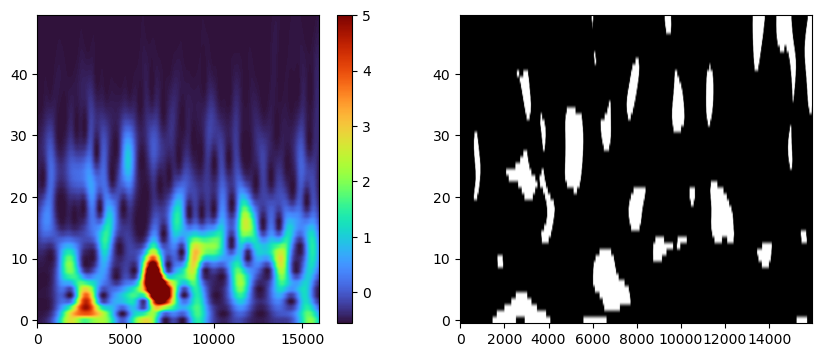

In [98]:
z = W_theta[0]
z = (z - z.mean()) / z.std()
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(z, aspect="auto", origin="lower", cmap="turbo", vmax=5)
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(
    detect_burts(W_theta[0], 5, 1, 0.1) > 0,
    aspect="auto",
    origin="lower",
    cmap="binary_r",
)

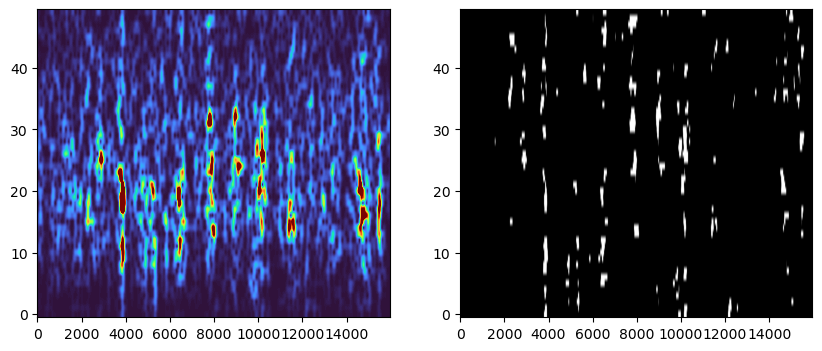

In [99]:
z = W_gamma[0]
z = (z - z.mean()) / z.std()
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(z, aspect="auto", origin="lower", cmap="turbo", vmax=5)
plt.subplot(1, 2, 2)
plt.imshow(
    detect_burts(W_gamma[0], 6, 2, 0.1) > 0,
    aspect="auto",
    origin="lower",
    cmap="binary_r",
)

In [34]:
pos = 0
z = (W_gamma[pos] - W_gamma[pos].std()) / W_gamma[pos].std()

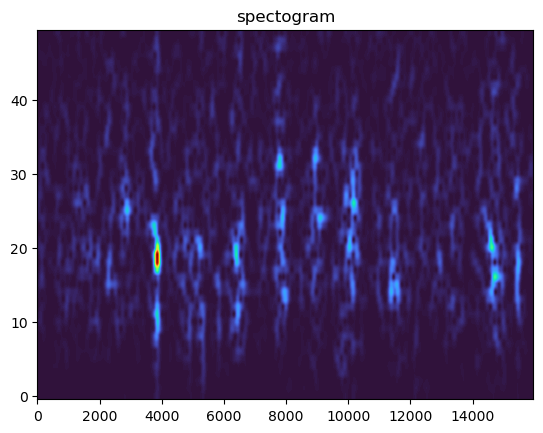

In [35]:
plt.imshow(W_gamma[pos], origin="lower", aspect="auto", cmap="turbo")
plt.title("spectogram")
plt.savefig("figures/frame1.png", dpi=300)

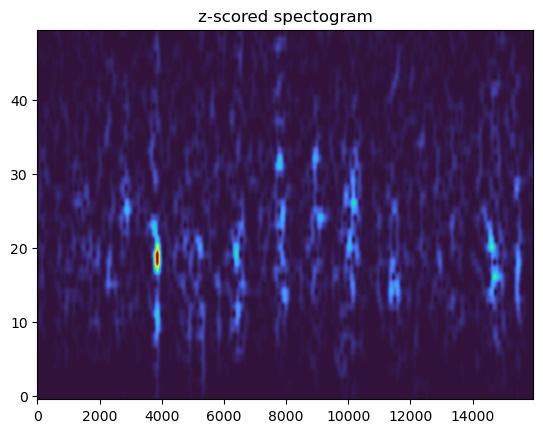

In [36]:
plt.imshow(
    z,
    origin="lower",
    aspect="auto",
    cmap="turbo",
)
plt.title("z-scored spectogram")
plt.savefig("figures/frame2.png", dpi=300)

In [37]:
frame = 3
for thr in [4, 3, 2, 1]:
    mask = detect_burts(W_gamma[pos], 5, thr, 0.1) > 0
    x = np.nan * (z * mask) + z
    plt.imshow(
        z * (np.where(mask, np.nan, mask) + 1),
        origin="lower",
        aspect="auto",
        cmap="turbo",
    )
    plt.title(f"threshold = {thr} STDs")
    plt.savefig(f"figures/frame{frame}.png", dpi=300)
    plt.close()
    frame = frame + 1
plt.tight_layout()

<Figure size 640x480 with 0 Axes>

#### Burst feature extraction

In [100]:
def extract_features(W, labeled_bursts):

    unique_labels = np.unique(labeled_bursts)[1:]
    nlabels = len(unique_labels)

    # Avg. and STD of each burst
    mean_amplitude = np.empty(nlabels)
    std_amplitude = np.empty(nlabels)

    # Avg., STD of the frequency of each burst and their weighted version
    mean_freq = np.empty(nlabels)
    std_freq = np.empty(nlabels)
    w_mean_freq = np.empty(nlabels)
    w_std_freq = np.empty(nlabels)
    peak_freq = np.empty(nlabels)

    # Avg., STD of the time of each burst and their weighted version
    mean_time = np.empty(nlabels)
    std_time = np.empty(nlabels)
    w_mean_time = np.empty(nlabels)
    w_std_time = np.empty(nlabels)
    t_start = np.empty(nlabels)
    t_stop = np.empty(nlabels)
    duration = np.empty(nlabels)

    labels_flattened = labeled_bursts.reshape(-1)
    W_stacked = W.stack(flat=("freqs", "times"))

    times = W_stacked.times.data
    freqs = W_stacked.freqs.data

    for pos, label in enumerate(unique_labels):
        mean_amplitude[pos] = W_stacked[labels_flattened == label].mean()
        std_amplitude[pos] = W_stacked[labels_flattened == label].std()

        mean_freq[pos] = freqs[labels_flattened == label].mean()
        std_freq[pos] = freqs[labels_flattened == label].std()
        w_mean_freq[pos], w_std_freq[pos] = weighted_avg_and_std(
            freqs[labels_flattened == label], W_stacked[labels_flattened == label]
        )
        peak_freq[pos] = freqs[labels_flattened == label].max()

        mean_time[pos] = times[labels_flattened == label].mean()
        std_time[pos] = times[labels_flattened == label].std()
        w_mean_time[pos], w_std_time[pos] = weighted_avg_and_std(
            times[labels_flattened == label], W_stacked[labels_flattened == label]
        )

        t_start[pos] = times[labels_flattened == label].min()
        t_stop[pos] = times[labels_flattened == label].max()

        duration[pos] = t_stop[pos] - t_start[pos]

    return (
        mean_amplitude,
        std_amplitude,
        mean_freq,
        std_freq,
        w_mean_freq,
        w_std_freq,
        peak_freq,
        mean_time,
        std_time,
        w_mean_time,
        w_std_time,
        t_start,
        t_stop,
        duration,
    )

In [102]:
def _for_batch(W):
    init = int(((W.max("times") - W.mean("times")) / W.std("times")).max().data.item())
    return detect_burts(W, init, 1, 0.1)


# define the function to compute in parallel
parallel, p_fun = parallel_func(_for_batch, verbose=False, n_jobs=20, total=100)

labeled_theta_bursts = parallel(p_fun(W) for W in W_theta[:100])

  0%|          |  : 0/100 [00:00<?,       ?it/s]

In [103]:
labeled_theta_bursts = np.stack(labeled_theta_bursts)

In [104]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- NumPy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values - average) ** 2, weights=weights)
    return (average, np.sqrt(variance))

In [105]:
feature_names = [
    "mean_amplitude",
    "std_amplitude",
    "mean_freq",
    "std_freq",
    "w_mean_freq",
    "w_std_freq",
    "peak_freq",
    "mean_time",
    "std_time",
    "w_mean_time",
    "w_std_time",
    "t_start",
    "t_stop",
    "duration",
]

features = {}

for name in feature_names:

    features[name] = []

for i in tqdm(range(100)):
    out = extract_features(W_theta[i], labeled_theta_bursts[i])
    for pos, name in enumerate(feature_names):
        features[name] += [out[pos]]



  0%|                                                                 | 0/100 [00:00<?, ?it/s]

  1%|▌                                                        | 1/100 [00:00<00:26,  3.70it/s]

  2%|█▏                                                       | 2/100 [00:00<00:26,  3.70it/s]

  3%|█▋                                                       | 3/100 [00:00<00:24,  3.92it/s]

  4%|██▎                                                      | 4/100 [00:01<00:23,  4.02it/s]

  5%|██▊                                                      | 5/100 [00:01<00:24,  3.95it/s]

  6%|███▍                                                     | 6/100 [00:01<00:21,  4.43it/s]

  7%|███▉                                                     | 7/100 [00:01<00:21,  4.40it/s]

  8%|████▌                                                    | 8/100 [00:01<00:21,  4.36it/s]

  9%|█████▏                                                   | 9/100 [00:02<00:21,  4.32it/s]

 10%|█████▌                           

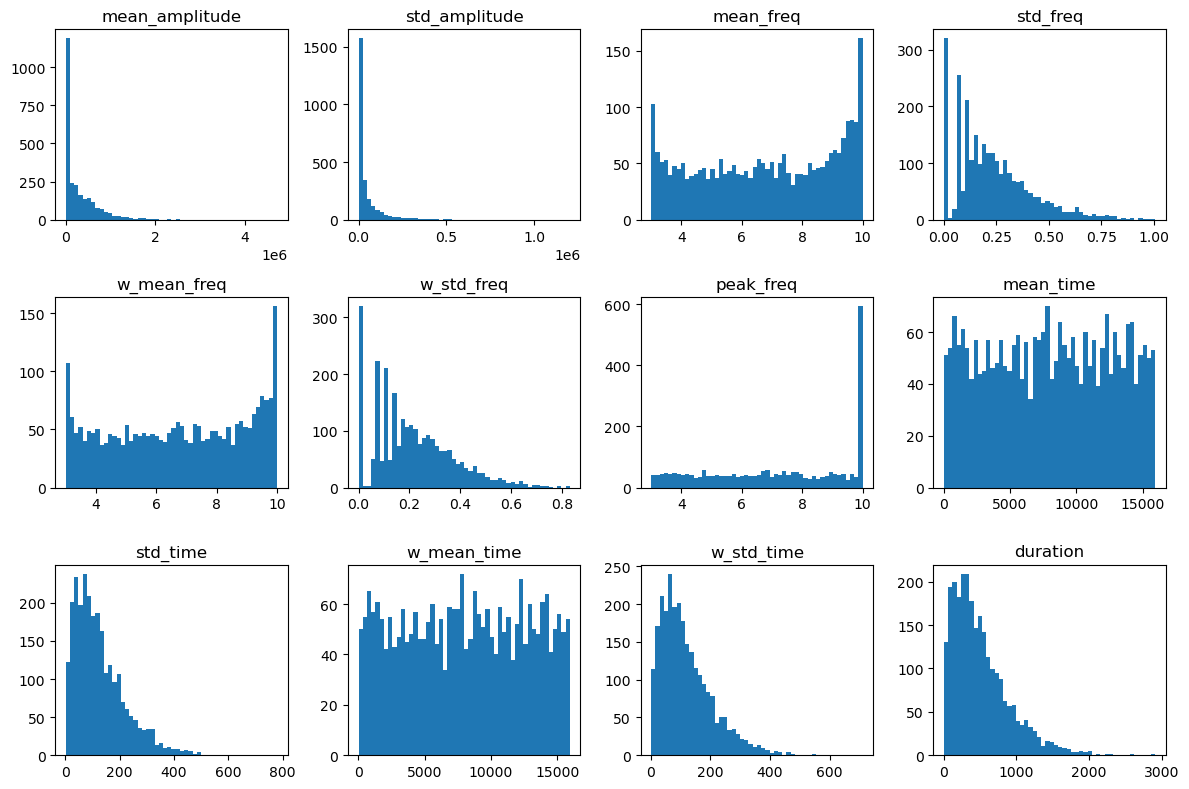

In [106]:
plt.figure(figsize=(12, 8))
pos = 1
for name in feature_names:
    if name not in ["t_start", "t_stop"]:
        plt.subplot(3, 4, pos)
        plt.hist(np.hstack(features[name]), 50)
        plt.title(name)
        pos = pos + 1
plt.tight_layout()

In [ ]:
def _for_batch(W):
    init = int(((W.max("times") - W.mean("times")) / W.std("times")).max().data.item())
    return detect_burts(W, init, 1, 0.1)


# define the function to compute in parallel
parallel, p_fun = parallel_func(_for_batch, verbose=False, n_jobs=20, total=100)

labeled_gamma_bursts = parallel(p_fun(W) for W in W_gamma[:100])

  0%|          |  : 0/100 [00:00<?,       ?it/s]

In [ ]:
labeled_gamma_bursts = np.stack(labeled_gamma_bursts)

In [ ]:
features_gamma = {}

for name in feature_names:

    features_gamma[name] = []

for i in tqdm(range(100)):
    out = extract_features(W_gamma[i], labeled_gamma_bursts[i])
    for pos, name in enumerate(feature_names):
        features_gamma[name] += [out[pos]]

In [ ]:
plt.figure(figsize=(12, 8))
pos = 1
for name in feature_names:
    if name not in ["t_start", "t_stop"]:
        plt.subplot(3, 4, pos)
        plt.hist(np.hstack(features_gamma[name]), 50)
        plt.title(name)
        pos = pos + 1
plt.tight_layout()

In [ ]:
import matplotlib as mpl

plt.figure(figsize=(9, 3.5))

plt.subplot(121)

plt.hist2d(
    np.hstack(features["mean_freq"]),
    np.log(np.hstack(features["mean_amplitude"])),
    bins=(20, 20),
    norm=mpl.colors.LogNorm(),
    cmap="turbo",
)
plt.ylabel("log(Amplitude)")
plt.xlabel("frequency [Hz]")
plt.title(r"$\theta$-bursts")
plt.colorbar()

plt.subplot(122)

plt.hist2d(
    np.hstack(features_gamma["mean_freq"]),
    np.log(np.hstack(features_gamma["mean_amplitude"])),
    bins=(20, 20),
    norm=mpl.colors.LogNorm(),
    cmap="turbo",
)
plt.ylabel("log(Amplitude)")
plt.xlabel("frequency [Hz]")
plt.title(r"$\gamma$-bursts")
plt.colorbar()

plt.tight_layout()

In [55]:
import numba as nb


@nb.njit
def overlaps(theta_timings: list, gamma_timings: list):
    n_theta = len(theta_timings)
    n_gamma = len(gamma_timings)

    n_overlaps = np.empty(n_gamma, dtype=np.int8)

    for i in range(n_gamma):
        temp = np.logical_and(
            theta_timings[:, 0] - gamma_timings[i, 0] < 0,
            theta_timings[:, 1] - gamma_timings[i, 0] > 0,
        )

        temp = np.logical_and(
            temp,
            np.logical_and(
                theta_timings[:, 0] - gamma_timings[i, 1] < 0,
                theta_timings[:, 1] - gamma_timings[i, 1] > 0,
            ),
        )

        n_overlaps[i] = temp.sum()

    return n_overlaps

In [56]:
n_overlaps = []

for i in range(100):

    T_theta = np.stack((features["t_start"][i], features["t_stop"][i]), axis=1)
    T_gamma = np.stack(
        (features_gamma["t_start"][i], features_gamma["t_stop"][i]), axis=1
    )

    n_overlaps += [overlaps(T_theta, T_gamma)]

In [57]:
n_overlaps = np.hstack(n_overlaps)
amplitudes = np.hstack(features_gamma["mean_amplitude"])

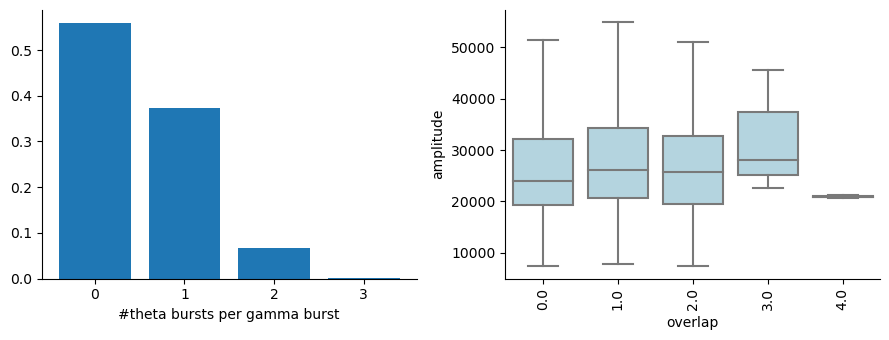

In [58]:
plt.figure(figsize=(9, 3.5))

ax = plt.subplot(121)
n, x = np.histogram(n_overlaps, bins=[0, 1, 2, 3, 4])
plt.bar(x[:-1], n / n.sum())
plt.xlabel("#theta bursts per gamma burst")
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
ax = plt.subplot(122)
import pandas as pd
import seaborn as sns

df = pd.DataFrame(
    np.stack((n_overlaps, amplitudes), axis=1), columns=["overlap", "amplitude"]
)
sns.boxplot(data=df, x="overlap", y="amplitude", showfliers=False, color="lightblue")
[ax.spines[key].set_visible(False) for key in ["top", "right"]]

plt.xticks(rotation=90)

plt.tight_layout()

In [66]:
SIZES = []
FREQS = []

for pos in tqdm(range(100)):

    times = W_gamma[pos].stack(flat=("freqs", "times")).times.data
    freqs = W_gamma[pos].stack(flat=("freqs", "times")).freqs.data

    labeled_bursts = labeled_gamma_bursts[pos].reshape(-1)

    unique_labels = np.unique(labeled_bursts)[1:]
    n_labels = len(unique_labels)

    S = np.zeros((n_labels, n_labels))
    F_min = np.zeros(n_labels)
    F_max = np.zeros(n_labels)
    F_mean = np.zeros(n_labels)

    for l_i in unique_labels - 1:
        F_min[l_i] = freqs[labeled_bursts == l_i + 1].min()
        F_max[l_i] = freqs[labeled_bursts == l_i + 1].max()
        F_mean[l_i] = freqs[labeled_bursts == l_i + 1].mean()

    for l_i in range(n_labels - 1):
        times_i = times[labeled_bursts == l_i + 1]
        s_i = len(times_i)
        for l_j in range(l_i, n_labels):
            if F_max[l_i] < F_min[l_j]:
                times_j = times[labeled_bursts == l_j + 1]
                s_j = len(times_j)
                S[l_i, l_j] = len(np.intersect1d(times_i, times_j)) / np.min((s_i, s_j))
    np.fill_diagonal(S, 0)
    SIZES += [S]
    FREQS += [F_mean]


100%|███████████████████████████████████████████████████████| 100/100 [00:44<00:00,  2.26it/s]


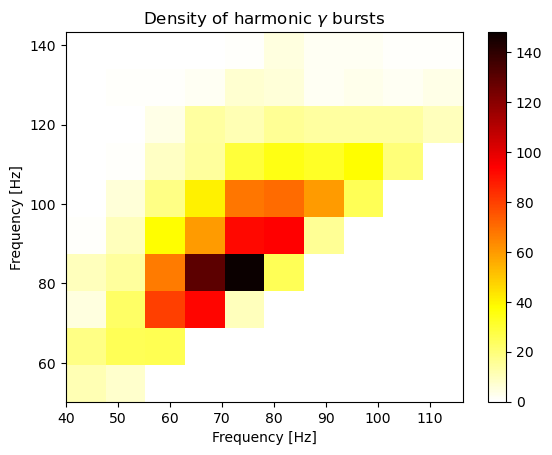

In [68]:
x, y = [], []
for i in range(len(SIZES)):
    pi, pj = np.where(SIZES[i] > 0.95)
    x += [FREQS[i][pi]]
    y += [FREQS[i][pj]]

x = np.hstack(x)
y = np.hstack(y)
plt.hist2d(x, y, cmap="hot_r")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Frequency [Hz]")
plt.title(r"Density of harmonic $\gamma$ bursts")
plt.colorbar()

In [64]:
SIZES = []
FREQS = []

for pos in tqdm(range(100)):

    times = W_theta[pos].stack(flat=("freqs", "times")).times.data
    freqs = W_theta[pos].stack(flat=("freqs", "times")).freqs.data

    labeled_bursts = labeled_theta_bursts[pos].reshape(-1)

    unique_labels = np.unique(labeled_bursts)[1:]
    n_labels = len(unique_labels)

    S = np.zeros((n_labels, n_labels))
    F_min = np.zeros(n_labels)
    F_max = np.zeros(n_labels)
    F_mean = np.zeros(n_labels)

    for l_i in unique_labels - 1:
        F_min[l_i] = freqs[labeled_bursts == l_i + 1].min()
        F_max[l_i] = freqs[labeled_bursts == l_i + 1].max()
        F_mean[l_i] = freqs[labeled_bursts == l_i + 1].mean()

    for l_i in range(n_labels - 1):
        times_i = times[labeled_bursts == l_i + 1]
        s_i = len(times_i)
        for l_j in range(l_i, n_labels):
            if F_max[l_i] < F_min[l_j]:
                times_j = times[labeled_bursts == l_j + 1]
                s_j = len(times_j)
                S[l_i, l_j] = len(np.intersect1d(times_i, times_j)) / np.min((s_i, s_j))
    np.fill_diagonal(S, 0)
    SIZES += [S]
    FREQS += [F_mean]


100%|███████████████████████████████████████████████████████| 100/100 [00:05<00:00, 19.15it/s]


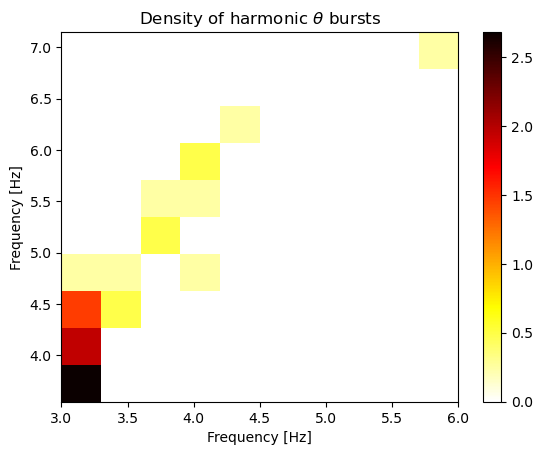

In [65]:
x, y = [], []
for i in range(len(SIZES)):
    pi, pj = np.where(SIZES[i] > 0.95)
    x += [FREQS[i][pi]]
    y += [FREQS[i][pj]]

x = np.hstack(x)
y = np.hstack(y)
plt.hist2d(x, y, cmap="hot_r", density=True)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Frequency [Hz]")
plt.title(r"Density of harmonic $\theta$ bursts")
plt.colorbar()

In [73]:
np.where( n_overlaps[:36] == 2 )

(array([15]),)

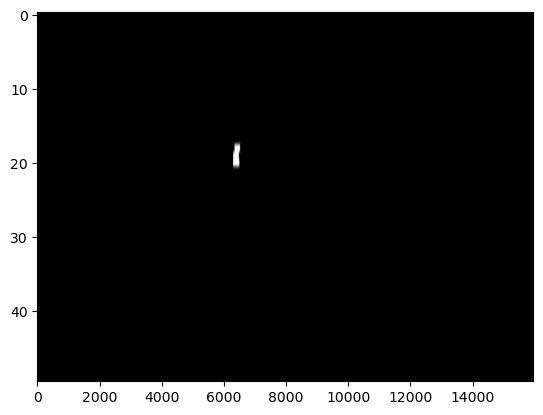

In [91]:
plt.imshow(  labeled_gamma_bursts[0] == 16, aspect="auto", cmap="binary_r" )

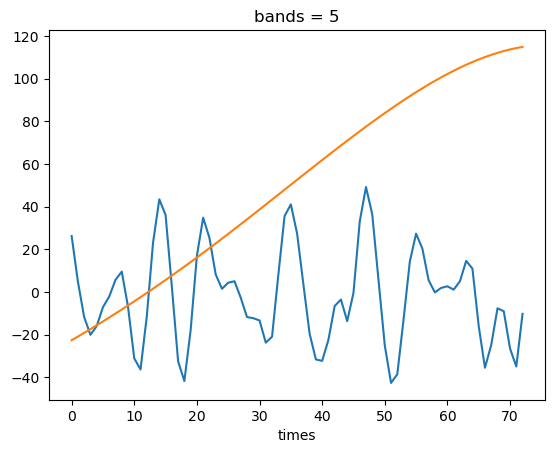

In [93]:
composite.isel(bands=1, times=slice(6539, 6612), batches=0).plot()
composite.isel(bands=0, times=slice(6539, 6612), batches=0).plot()


In [92]:
W_gamma.times.data[(labeled_gamma_bursts[0] == 26).sum(0) > 0]

array([6539, 6540, 6541, 6542, 6543, 6544, 6545, 6546, 6547, 6548, 6549,
       6550, 6551, 6552, 6553, 6554, 6555, 6556, 6557, 6558, 6559, 6560,
       6561, 6562, 6563, 6564, 6565, 6566, 6567, 6568, 6569, 6570, 6571,
       6572, 6573, 6574, 6575, 6576, 6577, 6578, 6579, 6580, 6581, 6582,
       6583, 6584, 6585, 6586, 6587, 6588, 6589, 6590, 6591, 6592, 6593,
       6594, 6595, 6596, 6597, 6598, 6599, 6600, 6601, 6602, 6603, 6604,
       6605, 6606, 6607, 6608, 6609, 6610, 6611, 6612])